In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [2]:
import os

results_path = "/home/jason/Applications/omnetpp-6.0.1/samples/florasat/simulations/dtsiot/results"
data_dir = "data"

rebuild_csv = False
if rebuild_csv:
    sca_files = [f for f in os.listdir(results_path) if f.endswith(".sca")]
    # vec_files = [f for f in os.listdir(results_path) if f.endswith(".vec")]

    for file_name in sca_files:
        print(file_name)
        os.system(f"opp_scavetool x {os.path.join(results_path, file_name)} -o {os.path.join(data_dir, file_name)}.csv")


sca_files = [f for f in os.listdir(data_dir) if ".sca" in f]
# vec_files = [f for f in os.listdir(data_dir) if ".vec" in f]

dfs = {
    "RESS-IoT": {
        "SCA": {},
        "VEC": {},
    },
    "DQ": {
        "SCA": {},
        "VEC": {},
    },
}

for file_name in sca_files:
    print(file_name)
    df = pd.read_csv(f"{os.path.join(data_dir, file_name)}", dtype=str)
    
    if ".sca" in file_name:
        numNodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
        file_type = "SCA"
    elif ".vec" in file_name:
        numNodes = int(df.loc[df['attrname'] == "**.nrOfNodes"].attrvalue.iloc[0])
        file_type = "VEC"
    
    if "RESS-IoT" in file_name:
        protocol = "RESS-IoT"
    elif "DQ" in file_name:
        protocol = "DQ"
    
    try:
        dfs[protocol][file_type][numNodes].append(df)
    except KeyError:
        dfs[protocol][file_type][numNodes] = [df]

for protocol in dfs:
    node_counts = list(dfs[protocol]["SCA"].keys())
    node_counts.sort()
    
    dfs[protocol]["SCA"] = {node_count: dfs[protocol]["SCA"][node_count] for node_count in node_counts}
    # dfs[protocol]["VEC"] = {node_count: dfs[protocol]["VEC"][node_count] for node_count in node_counts}

pd.set_option('display.max_rows', None)   

df = None

DQ-N=100-#2.sca.csv
RESS-IoT-N=500-#2.sca.csv
RESS-IoT-N=10-#17.sca.csv
DQ-N=100-#13.sca.csv
DQ-N=500-#13.sca.csv
DQ-N=2000-#9.sca.csv
RESS-IoT-N=5000-#8.sca.csv
RESS-IoT-N=500-#0.sca.csv
DQ-N=1000-#3.sca.csv
RESS-IoT-N=2000-#17.sca.csv
RESS-IoT-N=500-#6.sca.csv
DQ-N=5000-#9.sca.csv
DQ-N=3000-#6.sca.csv
RESS-IoT-N=4000-#15.sca.csv
RESS-IoT-N=3000-#6.sca.csv
DQ-N=100-#7.sca.csv
RESS-IoT-N=3000-#5.sca.csv
DQ-N=500-#20.sca.csv
DQ-N=5000-#16.sca.csv
RESS-IoT-N=100-#15.sca.csv
DQ-N=1000-#0.sca.csv
RESS-IoT-N=4000-#9.sca.csv
DQ-N=5000-#0.sca.csv
RESS-IoT-N=5000-#13.sca.csv
RESS-IoT-N=4000-#4.sca.csv
RESS-IoT-N=500-#1.sca.csv
RESS-IoT-N=100-#8.sca.csv
DQ-N=4000-#0.sca.csv
DQ-N=4000-#10.sca.csv
RESS-IoT-N=500-#19.sca.csv
DQ-N=1000-#6.sca.csv
RESS-IoT-N=1000-#7.sca.csv
DQ-N=100-#1.sca.csv
RESS-IoT-N=3000-#15.sca.csv
DQ-N=100-#3.sca.csv
RESS-IoT-N=4000-#12.sca.csv
RESS-IoT-N=4000-#0.sca.csv
RESS-IoT-N=500-#4.sca.csv
DQ-N=2000-#4.sca.csv
DQ-N=3000-#5.sca.csv
DQ-N=4000-#11.sca.csv
RESS-IoT-N=1000-

In [7]:
def get_throughput_bytes_per_hour(df):
    # Throughput B / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    bytes_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0]) / 8
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return (num_data_packets * bytes_per_data_packet) / sim_time_hours

def get_throughput_kilobytes_per_hour(df):
    # Throughput kB / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    kilobytes_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0]) / 8 / 1000
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return (num_data_packets * kilobytes_per_data_packet) / sim_time_hours

def get_jfi(df):
    # Jain's Fairness Index
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
    denominator = num_nodes * df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).pow(2).sum()
    numerator =  df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).sum() ** 2.0
    jfi = numerator / denominator if denominator != 0 else 0
    return jfi

def get_overhead_bytes(df):
    # Total bytes of overhead (Beacon, RTS, VCTS) or (ARS, FBP)
    possible_keys = [
        ('numARSPacketsSent', 'arsPacketLenBits'),
        ('numFBPPacketsSent', 'fbpPacketLenBits'),
        ('numRTSPacketsSent', 'rtsPacketLenBits'),
        ('numBeaconPacketsSent', 'beaconPacketLenBits'),
        ('numVCTSPacketsSent', 'vctsPacketLenBits'),
    ]
    
    overhead_bits = 0
    for key in possible_keys:
        try:
            total_num_packets = df.loc[df['name'] == key[0]].value.astype(int).sum()
            bits_per_packet = int(df.loc[df['name'] == key[1]].value.iloc[0])
            overhead_bits += (total_num_packets * bits_per_packet)
        except IndexError:
            pass

    return overhead_bits / 8

def get_data_bytes(df):
    bits_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0])
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return bits_per_data_packet * num_data_packets / 8

def get_avg_delay(df_sca):
    num_data_packets = int(df_sca.loc[df_sca['name'] == 'numDataPacketsReceived'].value.iloc[0])
    total_delay = float(df_sca.loc[df_sca['name'] == 'totalPacketDelay'].value.iloc[0])
    
    return total_delay / num_data_packets

def get_energy_satellite_DQ(df_sca):
    p_rx = 25.74 / 1000 # W
    p_tx = 389.4 / 1000 # W
    
    num_rounds = int(df_sca.loc[df_sca['name'] == "numFBPPacketsSent"].value.iloc[0])
    
    # Sat always sends a FBP
    t_fbp = float(df_sca.loc[df_sca['name'] == "fbpPacketTime"].value.iloc[0])
    e_fbp = num_rounds * p_tx * t_fbp
    
    # Sat always listens for all contention slots
    t_ars = float(df_sca.loc[df_sca['name'] == "arsPacketTime"].value.iloc[0])
    n_slots = int(df_sca.loc[df_sca['name'] == "numContentionSlots"].value.iloc[0])
    e_ars = num_rounds * p_rx * t_ars * n_slots
    
    # Sat only listens when a data packet will be sent len(dtq) != 0
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_data = num_data_packets * p_rx * t_data
    
    return e_fbp + e_ars + e_data

def get_energy_node_DQ(df_sca):
    p_rx = 25.74 / 1000 # W
    p_tx = 389.4 / 1000 # W
    
    num_rounds = int(df_sca.loc[df_sca['name'] == "numFBPPacketsSent"].value.iloc[0])
    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])

    # Nodes always listen for FBP
    t_fbp = float(df_sca.loc[df_sca['name'] == "fbpPacketTime"].value.iloc[0])
    e_fbp = num_nodes * num_rounds * p_rx * t_fbp
    
    # Nodes only send ARS when the constraints are met
    t_ars = float(df_sca.loc[df_sca['name'] == "arsPacketTime"].value.iloc[0])
    total_num_ars_packets_sent = df_sca.loc[df_sca['name'] == "numARSPacketsSent"].value.astype(int).sum()
    e_ars = total_num_ars_packets_sent * p_tx * t_ars
    
    # Only one or zero data packets can be sent each round
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_data = num_data_packets * p_tx * t_data
    
    return e_fbp + e_ars + e_data

def get_energy_satellite_RESSIOT(df_sca):
    p_rx = 25.74 / 1000 # W
    p_tx = 389.4 / 1000 # W
        
    num_rounds = int(df_sca.loc[df_sca['name'] == "numBeaconPacketsSent"].value.iloc[0])

    t_beacon = float(df_sca.loc[df_sca['name'] == "beaconPacketTime"].value.iloc[0])
    w_rx = float(df_sca.loc[df_sca['name'] == "wrx"].value.iloc[0])
    e_rp_sat = num_rounds * ((p_tx * t_beacon) + (p_rx * w_rx))
    
    t_vcts = float(df_sca.loc[df_sca['name'] == "vctsPacketTime"].value.iloc[0])
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_tp_sat = (num_rounds * p_tx * t_vcts) + (num_data_packets * p_rx * t_data)
    
    return e_rp_sat + e_tp_sat

def get_energy_node_RESSIOT(df_sca):
    p_rx = 25.74 / 1000 # W
    p_tx = 389.4 / 1000 # W
        
    num_rounds = int(df_sca.loc[df_sca['name'] == "numBeaconPacketsSent"].value.iloc[0])
    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])

    t_beacon = float(df_sca.loc[df_sca['name'] == "beaconPacketTime"].value.iloc[0])
    t_rts = float(df_sca.loc[df_sca['name'] == "rtsPacketTime"].value.iloc[0])
    total_num_rts_packets_sent = df_sca.loc[df_sca['name'] == "numRTSPacketsSent"].value.astype(int).sum()
    e_rp_nodes = (num_nodes * num_rounds * p_rx * t_beacon) + (total_num_rts_packets_sent * p_tx * t_rts)
    
    t_vcts = float(df_sca.loc[df_sca['name'] == "vctsPacketTime"].value.iloc[0])
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_tp_nodes = (num_rounds * num_nodes * p_rx * t_vcts) + (num_data_packets * p_tx * t_data)

    return e_rp_nodes + e_tp_nodes

def get_avg_energy_efficiency_node(key, df_sca):
    if key == "RESS-IoT": 
        e_nodes = get_energy_node_RESSIOT(df_sca)
    elif key == "DQ":
        e_nodes = get_energy_node_DQ(df_sca)

    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])
    
    return (get_data_bytes(df_sca) / num_nodes ) / (e_nodes / num_nodes)
    
def get_energy_efficiency_satellite(key, df_sca):
    if key == "RESS-IoT": 
        e_sat = get_energy_satellite_RESSIOT(df_sca)
    elif key == "DQ":
        e_sat = get_energy_satellite_DQ(df_sca)
    
    return get_data_bytes(df_sca) / e_sat

def get_energy_efficiency_network(key, df_sca):
    if key == "RESS-IoT": 
        e_network = get_energy_satellite_RESSIOT(df_sca) + get_energy_node_RESSIOT(df_sca)
    elif key == "DQ":
        e_network = get_energy_satellite_DQ(df_sca) + get_energy_node_DQ(df_sca)
    
    return get_data_bytes(df_sca) / e_network

In [8]:
metrics = {}

for key in dfs:
    metrics[key] = {}
    
    for node_count in dfs[key]["SCA"]:
        print(key, node_count)
        
        metrics[key][node_count] = {
            "Average Delay [seconds]": [],
            "Jain Fairness Index": [],
            "Throughput [kilobytes / hour]": [],
            "Overhead": [],
            "Data": [],
            "Satellite Energy Efficiency [bytes / joule]": [],
            "Average Energy Efficiency per Node [bytes / joule]": [],
            "Network Energy Efficiency [bytes / joule]": [],
        }
        
        for df_sca in dfs[key]["SCA"][node_count]:            
            metrics[key][node_count]["Average Delay [seconds]"].append(get_avg_delay(df_sca))
            metrics[key][node_count]["Jain Fairness Index"].append(get_jfi(df_sca))
            metrics[key][node_count]["Throughput [kilobytes / hour]"].append(get_throughput_kilobytes_per_hour(df_sca))
            metrics[key][node_count]["Overhead"].append(get_overhead_bytes(df_sca))
            metrics[key][node_count]["Data"].append(get_data_bytes(df_sca))
            metrics[key][node_count]["Satellite Energy Efficiency [bytes / joule]"].append(get_energy_efficiency_satellite(key, df_sca))
            metrics[key][node_count]["Average Energy Efficiency per Node [bytes / joule]"].append(get_avg_energy_efficiency_node(key, df_sca))
            metrics[key][node_count]["Network Energy Efficiency [bytes / joule]"].append(get_energy_efficiency_network(key, df_sca))
    
pprint.pprint(metrics)

RESS-IoT 10
RESS-IoT 100
RESS-IoT 500
RESS-IoT 1000
RESS-IoT 2000
RESS-IoT 3000
RESS-IoT 4000
RESS-IoT 5000
DQ 10
DQ 100
DQ 500
DQ 1000
DQ 2000
DQ 3000
DQ 4000
DQ 5000
{'DQ': {10: {'Average Delay [seconds]': [17.34693018385306,
                                         6.46422427026426,
                                         6.104993816870396,
                                         6.282603470084818,
                                         6.190980898152063,
                                         5.247028772315641,
                                         6.306808728550741,
                                         6.373691260170582,
                                         11.936366856641667,
                                         6.329434994764565,
                                         11.849680227340816,
                                         6.094563894384242,
                                         11.285311135935485,
                                         6.8192213

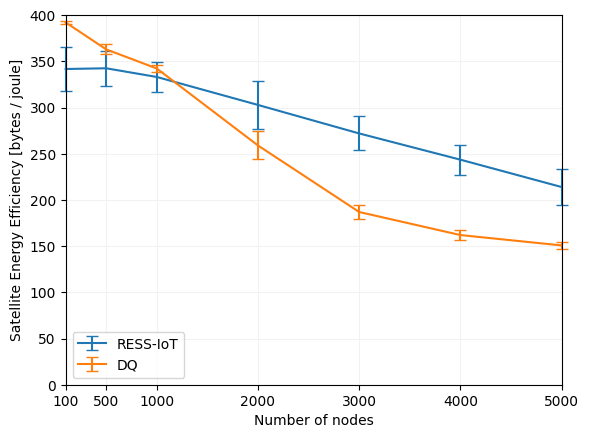

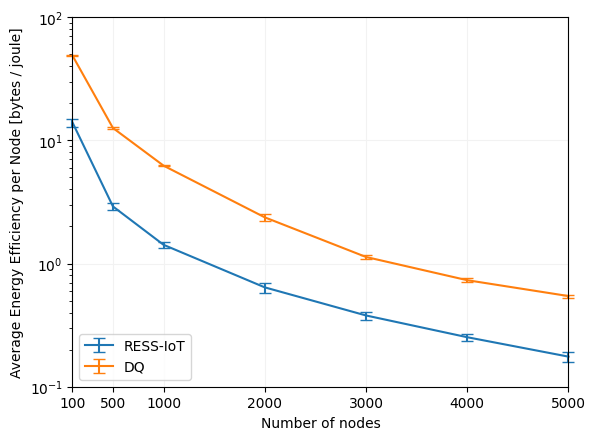

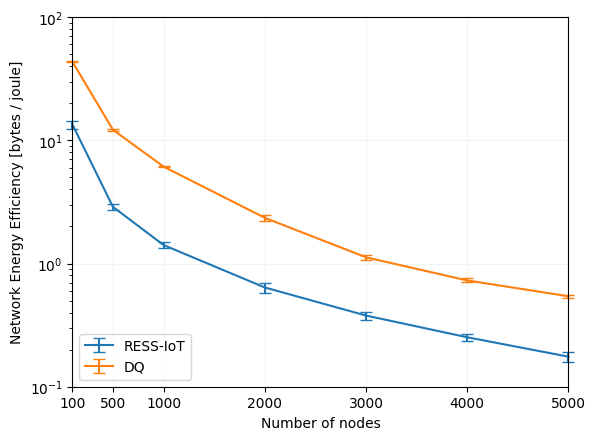

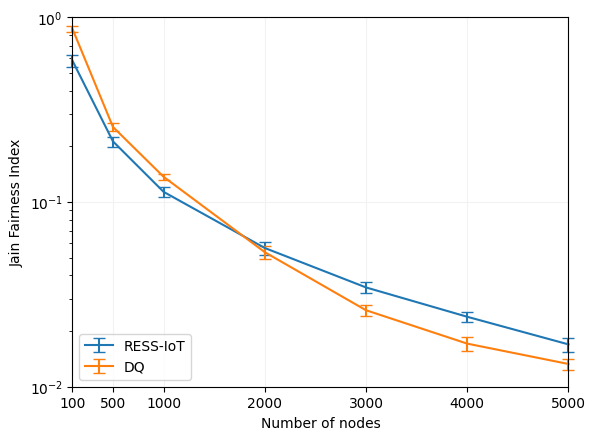

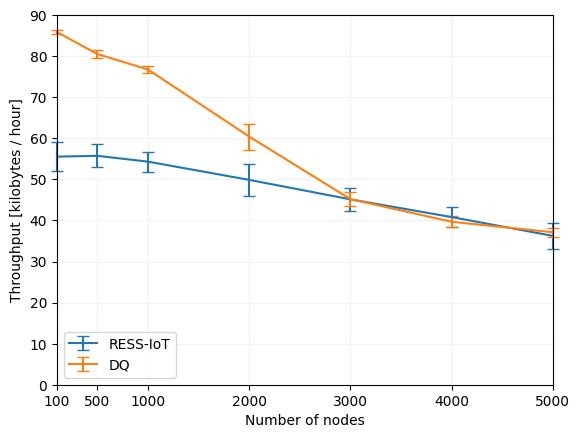

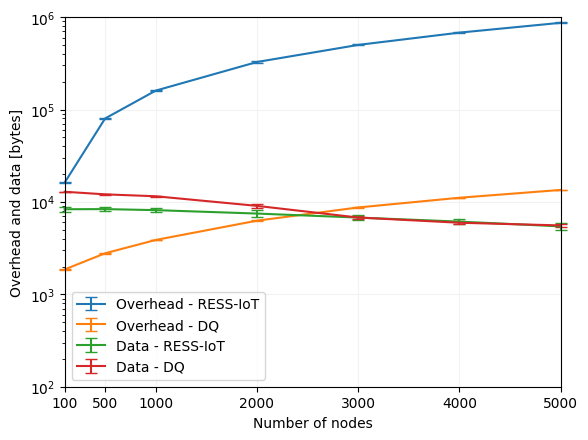

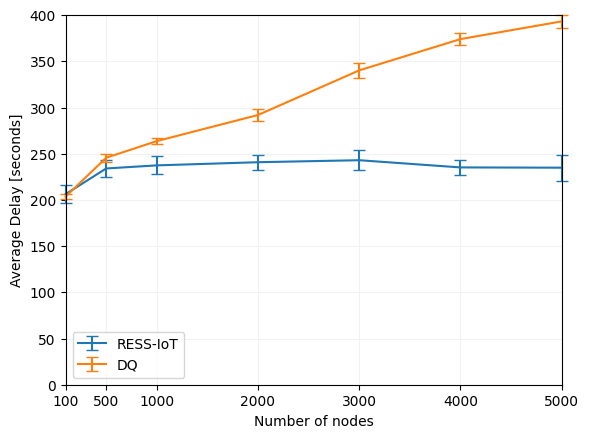

In [23]:
output_dir = "output_graphs"

def plot_runs(metric_names, label, ylims, is_log=False, show_metric_name=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for metric in metric_names:
        for key in dfs:
            x = list(metrics[key].keys())[1:] # skip count = 10
            ys = [metrics[key][node_count][metric] for node_count in x]
            y = [np.average(y) for y in ys]
            yerr = [np.std(y) for y in ys]

            key_label = key if not show_metric_name else f"{metric} - {key}"
            plt.errorbar(x, y, yerr=yerr, label=key_label, capsize=4, clip_on=False)
    
    plt.ylabel(label)
    plt.xlabel("Number of nodes")
    plt.legend(loc="lower left")
    plt.grid(linestyle='-', color='0.95')
    
    if is_log:
        plt.yscale("log")  
    
    plt.ylim(ylims[0], ylims[1])
    plt.xlim(100, 5000)
    
    x_ticks = np.append(ax.get_xticks()[1:], 100)
    x_ticks = np.append(x_ticks, 500)
    ax.set_xticks(x_ticks)

    plt.savefig(os.path.join(output_dir, f"{label.replace(' ', '_').replace('/', '_')}.png"))
    plt.show()

##### Satellite Energy Efficiency [bytes / joule]
metric = "Satellite Energy Efficiency [bytes / joule]"
plot_runs([metric], metric, [0, 400], False)

##### Average Energy Efficiency per Node [bytes / joule]
metric = "Average Energy Efficiency per Node [bytes / joule]"
plot_runs([metric], metric, [0.1, 100], True)

##### Network Energy Efficiency [bytes / joule]
metric = "Network Energy Efficiency [bytes / joule]"
plot_runs([metric], metric, [0.1, 100], True)

##### Jain Fairness Index
metric = "Jain Fairness Index"
plot_runs([metric], metric, [0.01, 1], True)

##### Throughput kilobytes / hour
metric = "Throughput [kilobytes / hour]"
plot_runs([metric], metric, [0, 90])

##### Overhead and data [bytes]
plot_runs(["Overhead", "Data"], "Overhead and data [bytes]", [100, 1000000], True, True)

##### Average Delay [seconds]
metric = "Average Delay [seconds]"
plot_runs([metric], metric, [0, 400])